Testing computational limits of MRF

1. runs fast when matrix is 24 or less (inference ~1min for 24x24 matrix)
2. 32 size limit is bc of np.array size not pgmpy algo
3. try approximate inference algo to speed up computation

thoughts: slowness of inference might be due to the fact that our graph is fully connected, not just edges for surrounding pixels

- could we assign cutoff for edges below a threshold of counts to decrease the size of the graph?
- is pomegranate a faster option?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from pgmpy.models import MarkovNetwork
from pgmpy.factors.discrete import DiscreteFactor
from pgmpy.inference import VariableElimination, BeliefPropagation, ApproxInference
from pgmpy.sampling import GibbsSampling
import daft
import random
import itertools
import pomegranate as pm


c:\Users\karae\anaconda3\envs\vrrl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
object_list = pd.read_excel('C:/Users/karae/github repositories/vrrl/cooccurrence/post_objects.xlsx', header=None)
objects = []

for i in range(len(object_list)):
    
    objects.append(object_list.iloc[i][0][6:])

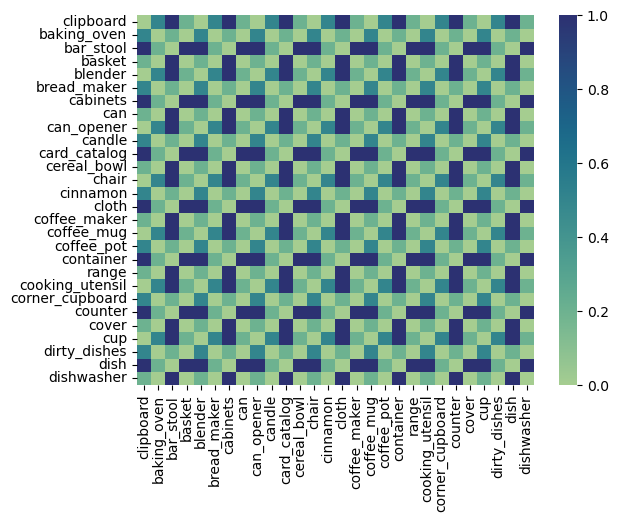

In [29]:
# counts
cooccur = np.array([[0,5,10,2],
                    [5,0,2,0],
                    [10,2,0,10],
                    [2,0,10,0]])

cooccur = cooccur/np.max(cooccur)

cooccur = np.tile(cooccur,(7,7))


# cooccur = np.random.randn(24,24)
# np.fill_diagonal(cooccur,0)

objects = objects[0:cooccur.shape[0]]

sns.heatmap(cooccur,xticklabels=objects,yticklabels=objects,cmap='crest')

cooccur = pd.DataFrame(cooccur,index=objects,columns=objects)

In [30]:
# instantiate network
G = MarkovNetwork()

# create graph (add nodes and edges)
nodes = objects
edges = list(itertools.combinations(objects,r=2))

G.add_nodes_from(nodes)
G.add_edges_from(edges)

In [31]:
# phi 
def compatibility(edge):
    
    tt = cooccur.loc[edge[0],edge[1]] / np.sum(cooccur.loc[edge[0],:])
    ft = (np.sum(cooccur.loc[:,edge[1]])-cooccur.loc[edge[0],edge[1]]) / (np.sum(np.triu(np.asarray(cooccur)))-np.sum(cooccur.loc[edge[0],:]))
    tf = 1 - tt
    ff = 1 - ft

    phi = [ff, ft, tf, tt]
    
    return phi

In [32]:
# create factors
for edge in G.edges():
    #print(compatibility(edge))
    factor = DiscreteFactor(edge, [2, 2], compatibility(edge))
    G.add_factors(factor)
    
#print(G.edges())
factor.assignment([0,1,2,3])

[[('dish', 0), ('dishwasher', 0)],
 [('dish', 0), ('dishwasher', 1)],
 [('dish', 1), ('dishwasher', 0)],
 [('dish', 1), ('dishwasher', 1)]]

In [37]:
# inference
G_infer = BeliefPropagation(G)
G_prob = G_infer.query(variables=['clipboard'], evidence={'container': 0})
print(G_prob)

+--------------+------------------+
| clipboard    |   phi(clipboard) |
+==============+==================+
| clipboard(0) |           0.2554 |
+--------------+------------------+
| clipboard(1) |           0.7446 |
+--------------+------------------+


In [5]:
X = np.random.randint(2, size=(50, 50))
model = pm.MarkovNetwork.from_samples(X)

MemoryError: 

In [ ]:
print(model.predict([[None, 0, None, 1, None]]))